In [164]:
from pathlib import Path
from tqdm import tqdm, tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.autograd import Variable
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("..")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()


X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    #X_train.append(np.mean(features, axis=0))
    
    X_train.append(features)
    #X_train.append([np.mean(features, axis=0),
    #                np.std(features, axis=0),
    #                np.min(features, axis=0),
    #                np.max(features, axis=0),
    #                np.median(features, axis=0)])
    
    y_train.append([label])
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)



def reduce_y(y):
    y_reduced = list()
    for y_ in y:
        y_reduced.append(np.array([y_[0]]))
    return np.array(y_reduced)


def train_val_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):
    """
    Split the input data into training, testing, and validation sets
    Args:
        X: input data
        y: labels
        train_size: proportion of data to be used for training
        val_size: proportion of data to be used for validation
        test_size: proportion of data to be used for testing
        random_state: seed for random number generator
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """
    np.random.seed(random_state)
    n_samples = X.shape[0]
    idx = np.random.permutation(n_samples)
    X, y = X[idx], y[idx]
    train_end = int(train_size * n_samples)
    val_end = int((train_size + val_size) * n_samples)
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end
                     :val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    return X_train, X_val, X_test, reduce_y(y_train), reduce_y(y_val), reduce_y(y_test)


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_train, y_train, train_size=0.8, val_size=.2, test_size=0)



Training data dimensions: (344, 4)


100%|████████████████████████████████████████| 344/344 [00:02<00:00, 147.11it/s]


In [148]:
X_train.shape

(275, 1000, 2048)

In [149]:
X_train = X_train[np.array([not y for y in np.squeeze(y_train).astype(bool)]),:,:]


In [150]:

X_val = X_val[np.array([not y for y in np.squeeze(y_val).astype(bool)]),:,:]

In [151]:
x = []

for img in X_train:
    for tile in img:
        x.append(tile)
        
X_train = np.array(x) #torch.from_numpy(np.array(x))


x = []

for img in X_val:
    for tile in img:
        x.append(tile)
        
X_val = np.array(x) #torch.from_numpy(np.array(x))

del x
        

In [152]:
del img

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# 1D Variational Autoencoder (VAE) using convolutional layers
# data: (batch_size, 1, seq_len)

#filters = 32

class Encoder(nn.Module):
    def __init__(self, seq_len, latent_dim, filters = [32, 64, 128, 256]):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.filters = filters
        self.conv1 = nn.Conv1d(1, filters[0], 3, stride=2, padding=1)
        self.dropout = nn.Dropout(.25)
        self.conv2 = nn.Conv1d(filters[0], filters[1], 3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(filters[1], filters[2], 3, stride=2, padding=1)
        self.conv4 = nn.Conv1d(filters[2], filters[3], 3, stride=2, padding=1)
        self.fc1 = nn.Linear(filters[3] * (seq_len // 16), self.latent_dim)
        #self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(latent_dim, latent_dim)
        self.fc32 = nn.Linear(latent_dim, latent_dim)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.filters[3] * (self.seq_len // 16))
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #return self.fc31(x), self.fc32(x)
        return x

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        #mu, logvar = self.encode(x)
        #z = self.reparameterize(mu, logvar)

        return self.encode(x)

class Decoder(nn.Module):
    def __init__(self, seq_len, latent_dim,  filters = [32, 64, 128, 256]):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.filters = filters
        
        #self.fc1 = nn.Linear(latent_dim, latent_dim)
        #self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(latent_dim, self.filters[3] * (seq_len // 16))

        self.deconv1 = nn.ConvTranspose1d(self.filters[3], self.filters[2], 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose1d(self.filters[2], self.filters[1], 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose1d(self.filters[1], self.filters[0], 3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose1d(self.filters[0], 1, 3, stride=2, padding=1, output_padding=1)

    def decode(self, z):
        #z = F.relu(self.fc1(z))
        #z = F.relu(self.fc2(z))
        z = F.relu(self.fc3(z))
        z = z.view(-1, self.filters[3], self.seq_len // 16)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        z = F.relu(self.deconv4(z))
        return z

    def forward(self, z):
        return self.decode(z)


class VAE(nn.Module):
    def __init__(self, seq_len, latent_dim, filters = [32, 64, 128, 256]):
        super(VAE, self).__init__()
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.encoder = Encoder(seq_len, latent_dim, filters=filters)
        self.decoder = Decoder(seq_len, latent_dim, filters=filters)

    def forward(self, x):
        z = self.encoder(x)
        z =  self.decoder(z)
        return z

    def inference(self, z):
        return self.decoder(z)

    def generate(self, batch_size):
        z = torch.randn(batch_size, self.latent_dim)
        return self.decoder(z)

    def reconstruct(self, x):
        z, _, _ = self.encoder(x)
        return self.decoder(z)

def train(model, optimizer, batch_size, x_train, x_val, epochs, loss_function, device):
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_loss = 0
        rng = np.random.default_rng()

        for batch in tqdm_notebook(range(0, 
                                         100,)):
                                         #x_train.shape[0], 
                                         #batch_size)):
            optimizer.zero_grad()
            #x = x_train[batch:batch + batch_size]
            #x = np.random.choice( x_train, batch_size, replace=False, axis=0)

            #x = np.random.Generator.choice(x_train, size=batch_size, replace=True, axis=0, shuffle=True)
            x = rng.choice(x_train, batch_size)
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)

            x_recon = model(x)
            loss = loss_function(x_recon, x)
            loss.backward()
            
            train_loss += loss.item()
            optimizer.step()
        #train_loss /= x_train.shape[0] / batch_size
        #train_loss /= 10000 / batch_size
        train_loss /= 100
        train_losses.append(train_loss)
        
        with torch.no_grad():

            val_loss = 0
            for batch in range(0, 
                               #x_val.shape[0], 
                               10,):
                               #batch_size):
                
                #x = x_val[batch:batch + batch_size]
                x = rng.choice(x_val, batch_size)
                x = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
                x_recon = model(x)
                
                loss = loss_function(x_recon, x)
                val_loss += loss.item()
            #val_loss /= x_val.shape[0] / batch_size
            val_loss /= 10
            #val_loss /= 1000 / batch_size
            val_loss = val_loss
            val_losses.append(val_loss)

        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
              .format(epoch + 1, epochs, train_loss, val_loss))
    return train_losses, val_losses


def loss_function(x_recon, x):
    recon_loss = F.mse_loss(x_recon, x, size_average=True)


    return recon_loss 





In [53]:
seq_len = X_train.shape[1]
latent_dim = 1024
batch_size = 64
epochs = 10
learning_rate = 1e-4

device = torch.device('mps')


FILTERS = [8,16, 32, 64]
model = VAE(seq_len, latent_dim, filters = FILTERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [120]:
learning_rate = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100


In [153]:
epochs = 200
model.to(device)
train_losses, val_losses = train(model, optimizer, batch_size, X_train, X_val, epochs, loss_function, device)

/var/folders/p8/_kjf3t992f18h9kf52z7snvw0000gn/T/ipykernel_88537/1180728587.py:113: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(range(0,


  0%|          | 0/100 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/owkin/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch [1/200], Train Loss: 0.0010, Val Loss: 0.0012


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/200], Train Loss: 0.0010, Val Loss: 0.0012


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/200], Train Loss: 0.0010, Val Loss: 0.0012


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/200], Train Loss: 0.0010, Val Loss: 0.0012


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/200], Train Loss: 0.0010, Val Loss: 0.0012


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/200], Train Loss: 0.0011, Val Loss: 0.0012


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/200], Train Loss: 0.0010, Val Loss: 0.0012


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/200], Train Loss: 0.0010, Val Loss: 0.0012


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/200], Train Loss: 0.0010, Val Loss: 0.0012


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/200], Train Loss: 0.0010, Val Loss: 0.0012


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/200], Train Loss: 0.0010, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/200], Train Loss: 0.0025, Val Loss: 0.0015


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/200], Train Loss: 0.0012, Val Loss: 0.0013


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/200], Train Loss: 0.0011, Val Loss: 0.0013


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/200], Train Loss: 0.0011, Val Loss: 0.0012


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [16/200], Train Loss: 0.0010, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [17/200], Train Loss: 0.0010, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [18/200], Train Loss: 0.0010, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [19/200], Train Loss: 0.0010, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20/200], Train Loss: 0.0010, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [21/200], Train Loss: 0.0010, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [22/200], Train Loss: 0.0010, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [23/200], Train Loss: 0.0010, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [24/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [25/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [26/200], Train Loss: 0.0009, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [27/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [28/200], Train Loss: 0.0009, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [29/200], Train Loss: 0.0009, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [30/200], Train Loss: 0.0009, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [31/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [32/200], Train Loss: 0.0009, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [33/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [34/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [35/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [36/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [37/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [38/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [39/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [40/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [41/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [42/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [43/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [44/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [45/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [46/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [47/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [48/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [49/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [50/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [51/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [52/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [53/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [54/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [55/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [56/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [57/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [58/200], Train Loss: 0.0009, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [59/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [60/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [61/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [62/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [63/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [64/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [65/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [66/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [67/200], Train Loss: 0.0009, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [68/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [69/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [70/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [71/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [72/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [73/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [74/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [75/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [76/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [77/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [78/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [79/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [80/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [81/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [82/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [83/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [84/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [85/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [86/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [87/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [88/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [89/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [90/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [91/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [92/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [93/200], Train Loss: 0.0009, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [94/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [95/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [96/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [97/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [98/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [99/200], Train Loss: 0.0009, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [100/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [101/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [102/200], Train Loss: 0.0009, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [103/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [104/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [105/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [106/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [107/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [108/200], Train Loss: 0.0012, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [109/200], Train Loss: 0.0009, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [110/200], Train Loss: 0.0009, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [111/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [112/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [113/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [114/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [115/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [116/200], Train Loss: 0.0009, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [117/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [118/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [119/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [120/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [121/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [122/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [123/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [124/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [125/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [126/200], Train Loss: 0.0009, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [127/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [128/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [129/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [130/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [131/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [132/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [133/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [134/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [135/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [136/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [137/200], Train Loss: 0.0009, Val Loss: 0.0011


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [138/200], Train Loss: 0.0009, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [139/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [140/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [141/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [142/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [143/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [144/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [145/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [146/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [147/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [148/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [149/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [150/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [151/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [152/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [153/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [154/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [155/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [156/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [157/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [158/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [159/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [160/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [161/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [162/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [163/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [164/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [165/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [166/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [167/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [168/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [169/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [170/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [171/200], Train Loss: 0.0011, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [172/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [173/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [174/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [175/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [176/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [177/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [178/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [179/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [180/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [181/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [182/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [183/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [184/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [185/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [186/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [187/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [188/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [189/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [190/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [191/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [192/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [193/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [194/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [195/200], Train Loss: 0.0009, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [196/200], Train Loss: 0.0008, Val Loss: 0.0010


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [197/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [198/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [199/200], Train Loss: 0.0008, Val Loss: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [200/200], Train Loss: 0.0008, Val Loss: 0.0009


In [154]:
def save_weights(model, name):
    #save model weights
    torch.save(model.state_dict(), name)

def load_weights(model, name):
    #load model weights
    model.load_state_dict(torch.load(name))
    model.eval()

In [155]:
save_weights(model, '4600AE')

In [140]:
!ls

400AE                 test_ae.ipynb         test_simple_GRU.ipynb
attention.ipynb       test_metadata.csv     test_simple_nn.ipynb
baseline.ipynb        test_mi-svm.ipynb     train_metadata.csv
model.onnx            test_recur.ipynb


In [156]:
#el x
x = torch.tensor(X_train[1:3], dtype=torch.float32).unsqueeze(1)

In [157]:
model = model.to('cpu')

In [158]:
with torch.no_grad():
    y_pred = model(x)

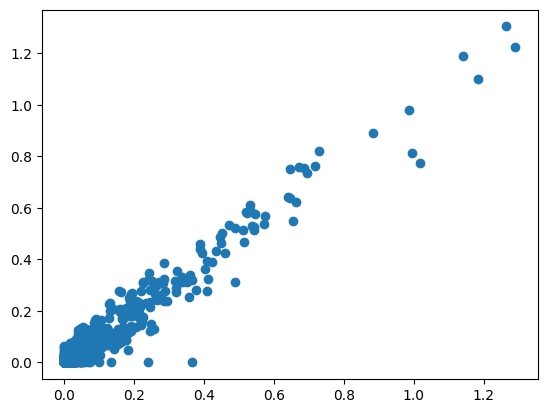

In [159]:
plt.scatter(np.squeeze(np.array(x[0].detach())),
    np.squeeze(np.array(y_pred[0].detach())))

#plt.xlim()
#plt.ylim(.0, .4)

In [160]:
X_train.min()

0.0

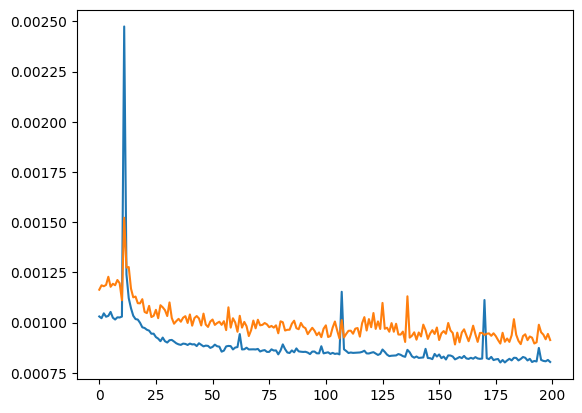

In [161]:
plt.plot(train_losses)
plt.plot(val_losses)

In [162]:
F.mse_loss(y_pred[1], x[1], size_average=True)

tensor(0.0010)

In [99]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(model)

18901985

In [100]:
from torchviz import make_dot


In [ ]:
input_names = ["Iris"]
output_names = [""]

torch.onnx.export(model, x, "model.onnx", input_names=input_names, output_names=output_names)

In [ ]:
!open model.onnx

In [ ]:
X_val.shape

## Distances

In [176]:
#X_val_pos = X_val[(np.squeeze(y_val) == 1)]
#X_val_neg = X_val[(np.squeeze(y_val) == 0)]

X_val_pos = X_train[(np.squeeze(y_train) == 1)][40:50]
X_val_neg = X_train[(np.squeeze(y_train) == 0)][40:50]

In [177]:
model = model.to('cpu')
#model = model.to(device)

In [217]:
with torch.no_grad():
    pos_mses = list()
    print('finding positive greatest MSEs')
    for idx_img in tqdm_notebook(range(X_val_pos.shape[0])):        
        
        max_mses = [0.0]*750
        
        for idx_tile in range(1000):
            to_pass = torch.tensor(np.array([X_val_pos[idx_img,idx_tile,:]]), dtype=torch.float32).unsqueeze(1)
            pred = model(to_pass)  
            
            mse = F.mse_loss(pred,
                             to_pass,
                            size_average=True)
            #mse = F.mse_loss(torch.from_numpy(np.array(pred)[0,0]),
            #                   torch.from_numpy(X_val_pos[idx_img,idx_tile,:]),
            #                   size_average=True)
            
            
            if mse>max_mses[0]:
                max_mses[0]=mse
                max_mses.sort()
        
        pos_mses.append(np.mean(max_mses))

            
            
with torch.no_grad():
    neg_mses = list()
    print('finding negative greatest MSEs')
    for idx_img in tqdm_notebook(range(X_val_neg.shape[0])):        
        max_mses = [0.0]*750
        
        for idx_tile in range(1000):
            to_pass = torch.tensor(np.array([X_val_neg[idx_img,idx_tile,:]]), dtype=torch.float32).unsqueeze(1)
            pred = model(to_pass)                    
            mse = F.mse_loss(torch.from_numpy(np.array(pred)[0,0]),
                               torch.from_numpy(X_val_neg[idx_img,idx_tile,:]),
                               size_average=True)
            
            if mse>max_mses[0]:
                max_mses[0]=mse
                max_mses.sort()
        neg_mses.append(np.mean(max_mses))

            

finding positive greatest MSEs


/var/folders/p8/_kjf3t992f18h9kf52z7snvw0000gn/T/ipykernel_88537/3462933276.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx_img in tqdm_notebook(range(X_val_pos.shape[0])):


  0%|          | 0/10 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/owkin/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


finding negative greatest MSEs


/var/folders/p8/_kjf3t992f18h9kf52z7snvw0000gn/T/ipykernel_88537/3462933276.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx_img in tqdm_notebook(range(X_val_neg.shape[0])):


  0%|          | 0/10 [00:00<?, ?it/s]

In [218]:

def plot_distribution(distrib, bins=40):
    
    #plot histogram
    plt.hist(distrib, bins=bins, density=True)
    #plt.show()




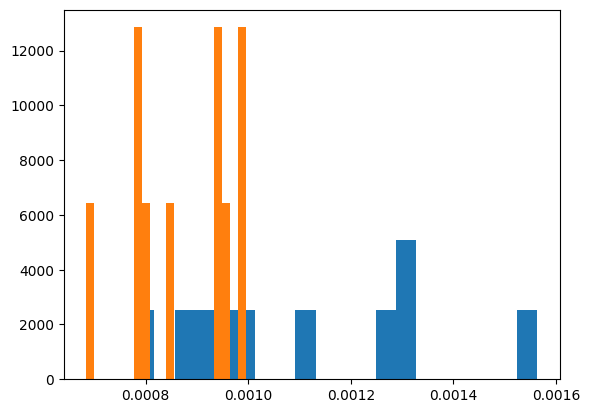

In [219]:
plot_distribution(pos_mses, bins=20)
plot_distribution(neg_mses, bins=20)






In [220]:
def box_plot(distrib):
    plt.boxplot(distrib)

In [221]:
def box_plot(distrib1, distrib2, name1, name2, title):
    #plot boxplot
    plt.boxplot([distrib1, distrib2], labels=[name1, name2])
    plt.title(title)
    plt.show()

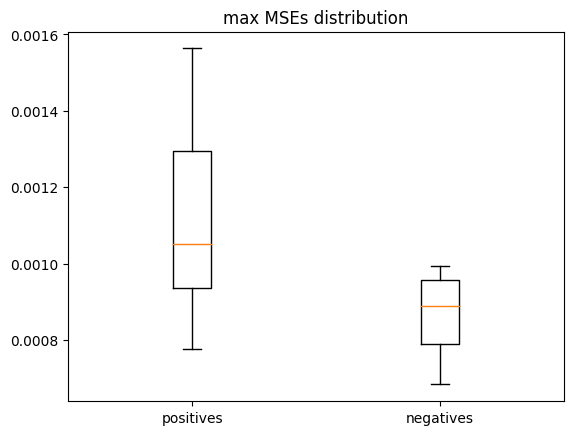

[]

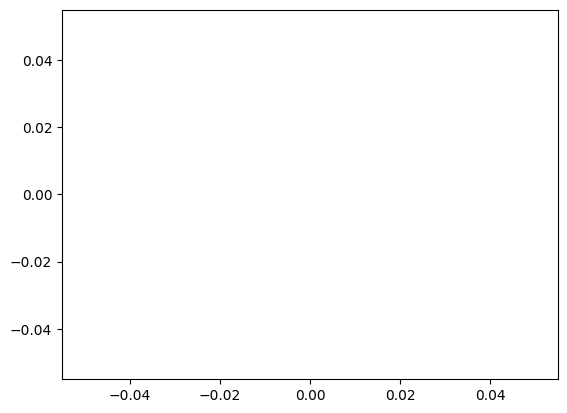

In [222]:
box_plot(pos_mses,neg_mses, 'positives', 'negatives', 'max MSEs distribution')
plt.plot()